<a href="https://colab.research.google.com/github/mraihanramadhan/Machine-Learning/blob/main/Week2_Linear%20Models_1.1.12%20Generalized%20Linear%20Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Poisson regression and non-normal loss

In [ ]:
print(__doc__)
# Authors: Christian Lorentzen <lorentzen.ch@gmail.com>
#          Roman Yurchak <rth.yurchak@gmail.com>
#          Olivier Grisel <olivier.grisel@ensta.org>
# License: BSD 3 clause
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Automatically created module for IPython interactive environment


In [ ]:
from sklearn.datasets import fetch_openml


df = fetch_openml(data_id=41214, as_frame=True).frame
df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
1,3.0,1.0,0.77000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
2,5.0,1.0,0.75000,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22
3,10.0,1.0,0.09000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
4,11.0,1.0,0.84000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0.0,0.00274,E,4.0,0.0,54.0,50.0,B12,Regular,3317.0,R93
678009,6114327.0,0.0,0.00274,E,4.0,0.0,41.0,95.0,B12,Regular,9850.0,R11
678010,6114328.0,0.0,0.00274,D,6.0,2.0,45.0,50.0,B12,Diesel,1323.0,R82
678011,6114329.0,0.0,0.00274,B,4.0,0.0,60.0,50.0,B12,Regular,95.0,R26


Average Frequency = 0.10070308464041304
Fraction of exposure with zero claims = 93.9%


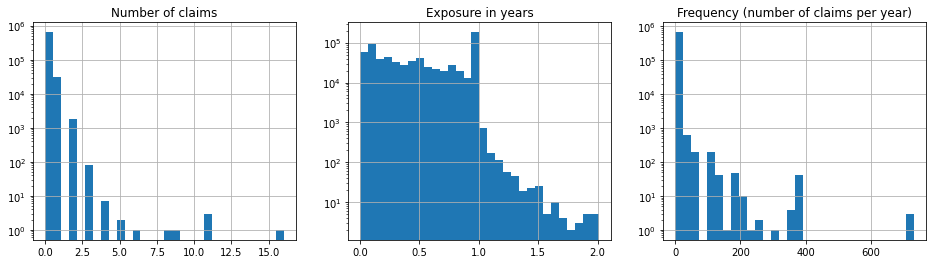

In [ ]:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]

print("Average Frequency = {}"
      .format(np.average(df["Frequency"], weights=df["Exposure"])))

print("Fraction of exposure with zero claims = {0:.1%}"
      .format(df.loc[df["ClaimNb"] == 0, "Exposure"].sum() /
              df["Exposure"].sum()))

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 4))
ax0.set_title("Number of claims")
_ = df["ClaimNb"].hist(bins=30, log=True, ax=ax0)
ax1.set_title("Exposure in years")
_ = df["Exposure"].hist(bins=30, log=True, ax=ax1)
ax2.set_title("Frequency (number of claims per year)")
_ = df["Frequency"].hist(bins=30, log=True, ax=ax2)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer


log_scale_transformer = make_pipeline(
    FunctionTransformer(np.log, validate=False),
    StandardScaler()
)

linear_model_preprocessor = ColumnTransformer(
    [
        ("passthrough_numeric", "passthrough",
            ["BonusMalus"]),
        ("binned_numeric", KBinsDiscretizer(n_bins=10),
            ["VehAge", "DrivAge"]),
        ("log_scaled_numeric", log_scale_transformer,
            ["Density"]),
        ("onehot_categorical", OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"]),
    ],
    remainder="drop",
)

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.33, random_state=0)

dummy = Pipeline([
    ("preprocessor", linear_model_preprocessor),
    ("regressor", DummyRegressor(strategy='mean')),
]).fit(df_train, df_train["Frequency"],
       regressor__sample_weight=df_train["Exposure"])

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_poisson_deviance


def score_estimator(estimator, df_test):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(df_test)

    print("MSE: %.3f" %
          mean_squared_error(df_test["Frequency"], y_pred,
                             sample_weight=df_test["Exposure"]))
    print("MAE: %.3f" %
          mean_absolute_error(df_test["Frequency"], y_pred,
                              sample_weight=df_test["Exposure"]))

    # Ignore non-positive predictions, as they are invalid for
    # the Poisson deviance.
    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(f"WARNING: Estimator yields invalid, non-positive predictions "
              f" for {n_masked} samples out of {n_samples}. These predictions "
              f"are ignored when computing the Poisson deviance.")

    print("mean Poisson deviance: %.3f" %
          mean_poisson_deviance(df_test["Frequency"][mask],
                                y_pred[mask],
                                sample_weight=df_test["Exposure"][mask]))


print("Constant mean frequency evaluation:")
score_estimator(dummy, df_test)

Constant mean frequency evaluation:
MSE: 0.564
MAE: 0.189
mean Poisson deviance: 0.625


In [ ]:
from sklearn.linear_model import Ridge


ridge_glm = Pipeline([
    ("preprocessor", linear_model_preprocessor),
    ("regressor", Ridge(alpha=1e-6)),
]).fit(df_train, df_train["Frequency"],
       regressor__sample_weight=df_train["Exposure"])

In [ ]:
print("Ridge evaluation:")
score_estimator(ridge_glm, df_test)

Ridge evaluation:
MSE: 0.560
MAE: 0.177
mean Poisson deviance: 0.601
